<center><span style="font-size: 36pt">Suicidal Post Detection</span></center>
<center><span style="font-size: 24pt">Anand Pajaniradjane, Capucine Hustin</span></center>

In [95]:
import os
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_curve, precision_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.utils import resample

<u><span style="font-size: 28pt"> 1. Preprocessing</span></u>

In [96]:
df = pd.read_csv("posts.csv")

In [97]:
df

,content,suicidal,data_type,sentiment
0,So I kind of want to die today - now with shit...,1,suicidal suicidal,NaN
1,An acquaintance threatend to kill herself twic...,1,suicidal suicidal,NaN
2,I waste hours with elaborate plans to Kill Mys...,1,suicidal suicidal,NaN
3,I hate my life and It's not really that I want...,1,suicidal suicidal,NaN
4,I don't want to be in pain when I die.,1,suicidal suicidal,NaN
...,...,...,...,...
11206,It's perfect. I've made excellent progress on ...,0,random_posts,positive
11207,Thanks #sigjeans,0,random_posts,positive
11208,Birthday Girl ? blessed to live another year ...,0,random_posts,positive
11209,It is a nice app. Thanks authorities for creat...,0,random_posts,positive


In [98]:
df=df.drop(columns=["data_type", "sentiment"])

<u><span style="font-size: 20pt"> i. Basic Text Cleaning</span></u>

In [99]:
#change to lowercase
df['content'] = df['content'].str.lower()

In [100]:
#Remove Punctations

from string import punctuation

def remove_punctuation(document):

    no_punct = ''.join([character for character in document if character not in punctuation])

    return no_punct

df['content'] = df['content'].apply(remove_punctuation)

In [101]:
#Remove Digits

def remove_digit(document):
    
    no_digit = ''.join([character for character in document if not character.isdigit()])

    return no_digit

df['content'] = df['content'].apply(remove_digit)

In [102]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\capuc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [103]:
from nltk.tokenize import word_tokenize

df['content'] = df['content'].apply(word_tokenize)
df.head()

,content,suicidal
0,"[so, i, kind, of, want, to, die, today, now, w...",1
1,"[an, acquaintance, threatend, to, kill, hersel...",1
2,"[i, waste, hours, with, elaborate, plans, to, ...",1
3,"[i, hate, my, life, and, its, not, really, tha...",1
4,"[i, dont, want, to, be, in, pain, when, i, die]",1


In [104]:
#Remove Stopwords

from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(document):

    words = [word for word in document if not word in stop_words]

    return words

df['content'] = df['content'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\capuc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [105]:
def remove_single_letter(document):
    
    words = [word for word in document if len(word)>1]

    return words

df['content'] = df['content'].apply(remove_single_letter)

In [106]:
#We use porter stemming

from nltk.stem import PorterStemmer

porter = PorterStemmer()

def stemmer(document):

    stemmed_document = [porter.stem(word) for word in document]

    return stemmed_document

df['content'] = df['content'].apply(stemmer)

In [107]:
df.head()

,content,suicidal
0,"[kind, want, die, today, shitti, illustr]",1
1,"[acquaint, threatend, kill, twice, past, call,...",1
2,"[wast, hour, elabor, plan, kill, run, away]",1
3,"[hate, life, realli, want, die, dont, want]",1
4,"[dont, want, pain, die]",1


<u><span style="font-size: 20pt"> ii. The document-term matrix</span></u>

In [108]:
# Detokenization (the sklearn package that we'll use performs tokenization automatically)

from nltk.tokenize.treebank import TreebankWordDetokenizer

df['content'] = df['content'].apply(TreebankWordDetokenizer().detokenize)

In [120]:
from sklearn.feature_extraction.text import CountVectorizer

countvec = CountVectorizer(min_df=0.005)

sparse_dtm = countvec.fit_transform(df['content'])
sparse_dtm

<11211x264 sparse matrix of type '<class 'numpy.int64'>'
	with 44796 stored elements in Compressed Sparse Row format>

`CountVectorizer` transforms our data into a 'Compressed Sparse Format' matrix. Storing the dtm in this format saves a lot of memory. We can then build a new `pandas` dataframe from this sparse dtm.

In [121]:
dtm = pd.DataFrame(sparse_dtm.toarray(), columns=countvec.get_feature_names_out(), index=df.index)
dtm

,abl,actual,ad,add,afraid,ago,almost,alon,alreadi,also,...,wont,work,world,would,wrong,ye,yeah,year,yet,your
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11206,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11207,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11208,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
11209,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [122]:
frequencies = dtm.sum().sort_values(ascending=False)
print(frequencies[frequencies > 50])

kill      2296
want      2071
die       1867
im        1348
app       1041
          ... 
howev       59
listen      59
wrong       58
turn        58
hell        57
Length: 264, dtype: int64


<u><span style="font-size: 28pt"> 2. Supervised Learning </span></u>

In [123]:
df

,content,suicidal
0,kind want die today shitti illustr,1
1,acquaint threatend kill twice past call polic ...,1
2,wast hour elabor plan kill run away,1
3,hate life realli want die dont want,1
4,dont want pain die,1
...,...,...
11206,perfect ive made excel progress newli form hab...,0
11207,thank sigjean,0
11208,birthday girl bless live anoth year celebr lov...,0
11209,nice app thank author creat app,0


In [124]:
from sklearn.model_selection import train_test_split
y = df['suicidal'].astype('int32')
X = dtm

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=88)
X_train.shape, X_test.shape

((7847, 264), (3364, 264))

In [126]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix

# Initializing models with a focus on recall
models = {
    'Dummy Classifier': DummyClassifier(strategy='most_frequent'),
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(probability=True, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier()
}

# DataFrame to store results
results_df = pd.DataFrame()

# Training and predicting with each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', zero_division=0)
    roc_auc = roc_auc_score(y_test, y_prob)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    tpr = tp / (tp + fn)  # True Positive Rate
    tnr = tn / (tn + fp)  # True Negative Rate
    fpr = fp / (tn + fp)  # False Positive Rate
    fnr = fn / (tp + fn)  # False Negative Rate

    # Creating a temporary DataFrame to hold current results
    temp_df = pd.DataFrame({
        "Model": [name],
        "Accuracy": [acc],
        "Precision": [prec],
        "Recall": [recall],
        "F1-Score": [fscore],
        "ROC AUC": [roc_auc],
        "TPR": [tpr],
        "TNR": [tnr],
        "FPR": [fpr],
        "FNR": [fnr]
    })

    # Concatenating with the main DataFrame
    results_df = pd.concat([results_df, temp_df], ignore_index=True)

In [127]:
# Display the DataFrame
print(results_df)

                 Model  Accuracy  Precision    Recall  F1-Score   ROC AUC  \
0     Dummy Classifier  0.669144   0.000000  0.000000  0.000000  0.500000   
1  Logistic Regression  0.991082   0.975417  0.998203  0.986679  0.999240   
2        Decision Tree  0.988109   0.979446  0.984726  0.982079  0.989434   
3                  SVM  0.986326   0.977619  0.981132  0.979372  0.997330   
4        Random Forest  0.992271   0.979700  0.997305  0.988424  0.998746   
5    Gradient Boosting  0.990785   0.975395  0.997305  0.986228  0.998731   

        TPR       TNR       FPR       FNR  
0  0.000000  1.000000  0.000000  1.000000  
1  0.998203  0.987561  0.012439  0.001797  
2  0.984726  0.989782  0.010218  0.015274  
3  0.981132  0.988894  0.011106  0.018868  
4  0.997305  0.989782  0.010218  0.002695  
5  0.997305  0.987561  0.012439  0.002695  


RAJOUTER NN ET RAJOUTER GRIDSEARCH

In [136]:
import torch 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf

In [137]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop

tf.random.set_seed(88)


model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],))) 
model.add(Dense(1, activation='sigmoid'))


opt = RMSprop()
model.compile(optimizer=opt,
              loss='binary_crossentropy', 
              metrics=['accuracy'])


model.fit(X_train, y_train, epochs=5, batch_size=128, validation_split=0.2)

c:\Users\capuc\anaconda3\envs\bear\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8899 - loss: 0.4969 - val_accuracy: 0.9790 - val_loss: 0.1756
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9816 - loss: 0.1372 - val_accuracy: 0.9943 - val_loss: 0.0515
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9886 - loss: 0.0490 - val_accuracy: 0.9968 - val_loss: 0.0252
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9910 - loss: 0.0303 - val_accuracy: 0.9968 - val_loss: 0.0196
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9935 - loss: 0.0241 - val_accuracy: 0.9975 - val_loss: 0.0176


In [138]:
y_prob = model.predict(X_test)
y_pred=(y_prob>0.5).astype(int)


106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [139]:
acc = accuracy_score(y_test, y_pred)
prec, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', zero_division=0)
roc_auc = roc_auc_score(y_test, y_prob)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

tpr = tp / (tp + fn)  # True Positive Rate
tnr = tn / (tn + fp)  # True Negative Rate
fpr = fp / (tn + fp)  # False Positive Rate
fnr = fn / (tp + fn)  # False Negative Rate

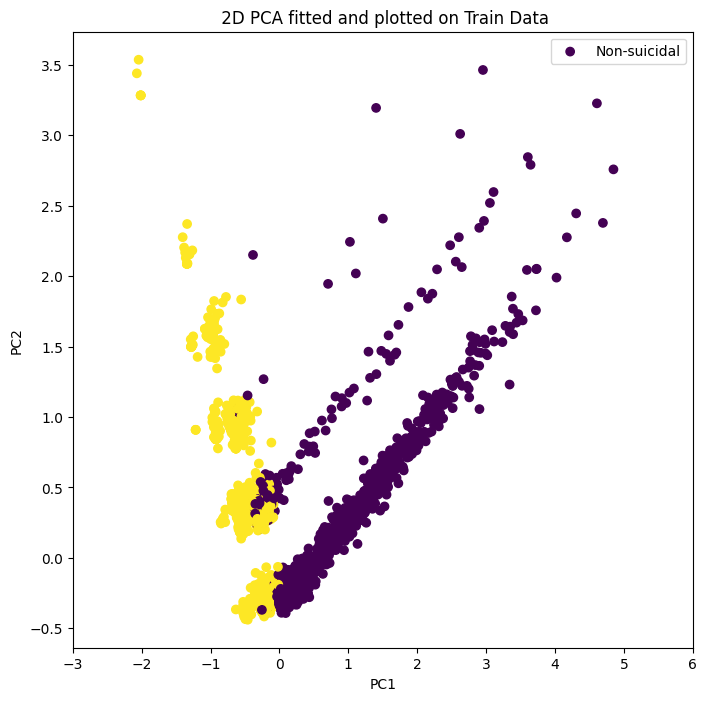

In [129]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_train)

#plot the PCA
plt.figure(figsize=(8,8))
plt.scatter(principalComponents[:,0], principalComponents[:,1], c=y_train)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xlim(-3, 6)
plt.legend(['Non-suicidal', 'Suicidal'])
plt.title(' 2D PCA fitted and plotted on Train Data')
plt.show()

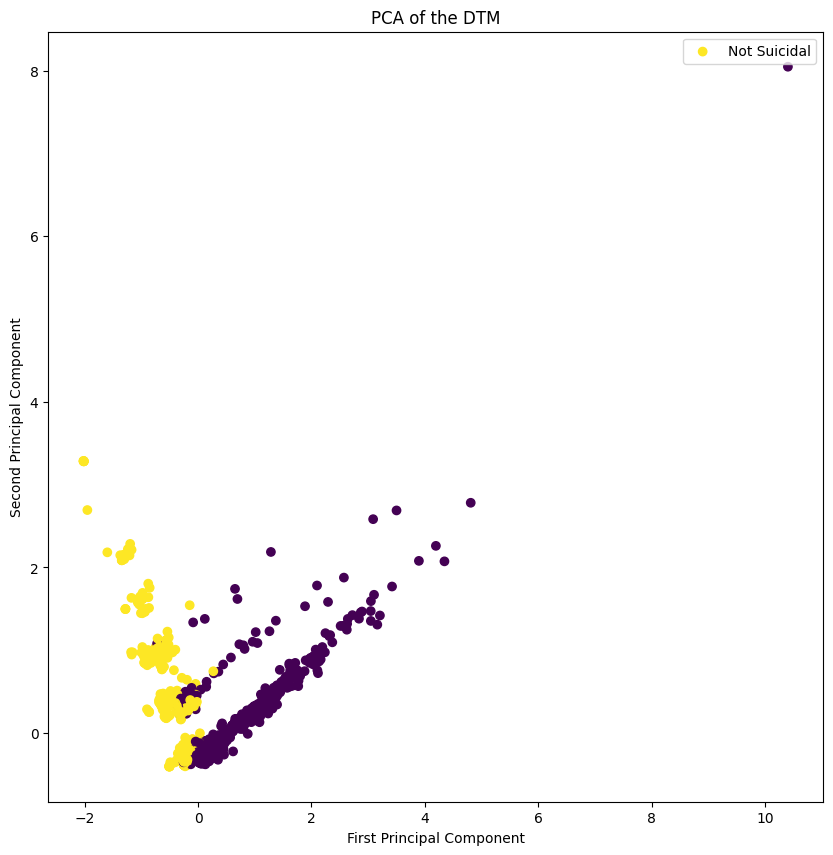

In [131]:
#now same thing for the test data
plt.figure(figsize=(10, 10))
plt.scatter(pca.transform(X_test)[:, 0], pca.transform(X_test)[:, 1], c=y_test)
plt.legend(['Not Suicidal', 'Suicidal'])
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of the DTM')
plt.show()

In [135]:
#now in 3D with plotly
import plotly.express as px
pca = PCA(n_components=3)
pca.fit(X_train)
dtm_train_pca = pca.transform(X_train)
dtm_train_pca = pd.DataFrame(dtm_train_pca, columns=['PC1', 'PC2', 'PC3'])
dtm_train_pca['suicidal'] = y_train.values
fig = px.scatter_3d(dtm_train_pca, x='PC1', y='PC2', z='PC3', color='suicidal')
fig.show()

In [133]:
#Becaues the 3D PCA works well, we are going to use it to do some prediction on the test data with kNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

pca = PCA(n_components=2)
dtm_train_pca = pca.fit_transform(X_train)
dtm_test_pca = pca.transform(X_test)

for n_neighbors in [1, 3, 5, 10, 20, 50]:
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(dtm_train_pca, y_train)
    predictions = knn.predict(dtm_test_pca)
    print('n_neighbors:', n_neighbors)
    FNR = np.sum((predictions == 0) & (y_test == 1)) / np.sum(y_test == 1)
    precision = np.sum((predictions == 1) & (y_test == 1)) / np.sum(predictions == 1)
    print('FNR:', FNR)
    print('precision:', precision)
    print('---------------------------------------------------')

n_neighbors: 1
FNR: 0.055705300988319856
precision: 0.951131221719457
---------------------------------------------------
n_neighbors: 3
FNR: 0.04582210242587601
precision: 0.957619477006312
---------------------------------------------------
n_neighbors: 5
FNR: 0.039532794249775384
precision: 0.9527629233511586
---------------------------------------------------
n_neighbors: 10
FNR: 0.04043126684636118
precision: 0.957847533632287
---------------------------------------------------
n_neighbors: 20
FNR: 0.03863432165318958
precision: 0.9579230080572964
---------------------------------------------------
n_neighbors: 50
FNR: 0.042228212039532795
precision: 0.9577717879604672
---------------------------------------------------
